# LSM CONTROLLER PARA MANTER O BAXTER TOCANDO A MESA

# A LSM FOI CRIADA A PARTIR DOS DADOS OBTIDOS COM UM PID PROJETADO COM O MESMO OBJETIVO


# EXPERIMENTOS REALIZADOS: 
# 0-99 no caderno (superfície mole), sobre a mesa, sem inclinação.
# 100-199 Quadro branco
# 200-249 Quadro branco inclinado no lado oposto ao robô (8mm) 
# 250-299 Quadro branco inclinado no lado direito do robô (8mm) 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 12}

plt.rc('font', **font)

import numpy
import rospy
import baxter_interface


import save_load_file as slf
import sys
from BEE import *

In [7]:
working_frequency = 100.0


#simulation type
#platform = "gazeboBaxter"
platform = "realBaxter"

trial_number = 0
total_trials = 100

##--data filenames--
input_filename = "BaxterArm_VREP_simulation_data/square/XY_movement_square_+0.5cm"
#input_filename = "BaxterArm_VREP_simulation_data/square/XY_movement_square_AJUSTABLE_0.25cm"
#input_filename = "XY_movement_square_HIGHTABLE3_free"

input_folder = "PIDs_DATA_FOR_THE_LSM"
data_folder = "PIDs_LSM"
sim_type = "with_PID_0.5cm"

##
limb = "left"
movtimeout = 1.0 #seconds
armspeed = 0.3 #percentage of arm speed
#[S0, S1, E1, W1]: [-0.60048157 -0.75280726  2.09665728  0.24717198] : 0.0
#[S0, S1, E1, W1]: [-0.60068953 -0.76690102  2.10270405  0.25267634] : +0.5cm
#[S0, S1, E1, W1]: [-0.60048157 -0.75280726  2.09665728  0.24717198] : +1cm
#[S0, S1, E1, W1]: [-0.60131329 -0.80917645  2.11977959  0.27020329] : +2cm




# Total time spent during the movement (in seconds)
MT = 2.0

# Simulation time step (in seconds)
time_step = 2/1000.0
total_steps = int(MT/time_step)

# S0, S1, E1 and W1 are the Baxter's joint names
# vel_x and vel_y are the velocities from accelerometer data 
# Four joints + 2 velocities => Six input variables
Number_of_input_variables=2 # defines how the liquid is going to be divided to receive the inputs

#
# Number of neurons at each input layer (defines the INPUT resolution of the system)
#
# >>>>>>>>> It MUST be smaller or equal to (NofN/Number_of_input_variables) <<<<<<<<<<<
#
Ninput = 100


#
# Set points of the PID controller, they are just used here to compare results
#
force_sensor_setpoint = -2.0
range_sensor_setpoint = 15.7

#LIQUID CONFIGURATION (MUSTBE THE SAME AS THE TRAINING)

#
# Liquid's shape
#
net_shape = numpy.array([8,5,5])

number_of_liquids = 5
liquids_used = [1,2,3,4] #liquid nº 0 is not used here because it was a bad one

In [8]:
range_sensor_limits = numpy.array([15. , 18.])
IR_range = range_sensor_limits[1]-range_sensor_limits[0]
range_delta = (range_sensor_limits[0]+IR_range/2)

force_sensor_limits = numpy.array([-10. , 2.])
force_range = force_sensor_limits[1]-force_sensor_limits[0]
force_delta = (force_sensor_limits[0]+force_range/2)

input_values_normalized=numpy.empty((Ninput,Number_of_input_variables))
for ji in range(Number_of_input_variables):
        input_values_normalized[:,ji]=numpy.linspace(-1,1,Ninput)
    
def generates_input_spikes(range_sensor,force_sensor):
    temp_IR=(range_sensor-range_delta)/(IR_range/2.)
    temp_Force=(force_sensor-force_delta)/(force_range/2.)
    
    normalized_IR=abs(input_values_normalized[:,0]-temp_IR).argmin()
    normalized_Force=abs(input_values_normalized[:,1]-temp_Force).argmin()

    return normalized_IR,normalized_Force

In [9]:
liqseeds=numpy.load(data_folder+"/"+"Contoller_liqseeds.npy") 
for i in liquids_used:    
    print "Liquid %d:" % i, liqseeds[i]

Liquid 1: [6414 8475 7022 1657 8307 5933]
Liquid 2: [5772 3395 5210 3482  288  759]
Liquid 3: [7898 1411 6211 2244  858 8653]
Liquid 4: [6489 9401 4603 5848 2598 5854]


<IPython.core.display.Javascript object>


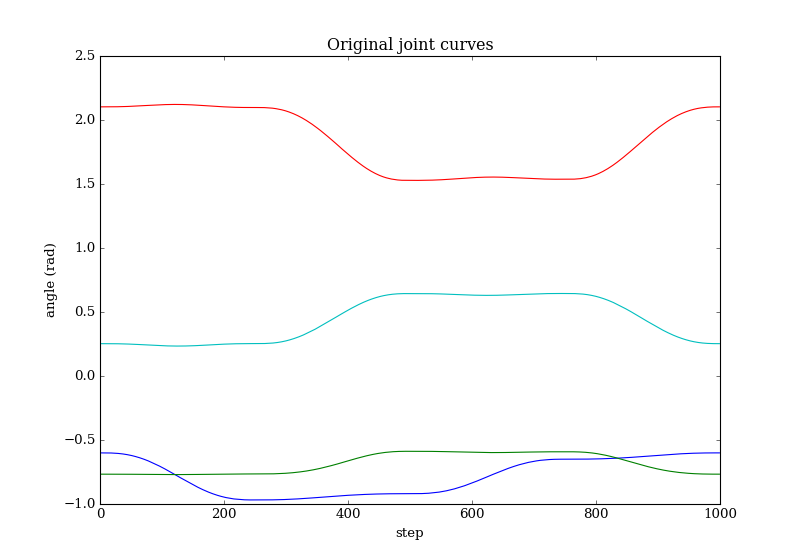

In [10]:
original_joints=numpy.zeros((0,4)) #creates an empty array with the right shape...
temp=numpy.load("./"+input_filename+".npy")
original_joints=numpy.concatenate((original_joints,temp[:1000]))

joints=numpy.copy(original_joints)

plt.figure(figsize=(10,7))
plt.plot(joints)
plt.title("Original joint curves")
plt.ylabel("angle (rad)")
plt.xlabel("step")
plt.show()

In [11]:
from sensor_msgs.msg import Range

class BaxterRangeSensor():
    def __init__(self):
        self.distance = 0
        sensor_name = "/robot/range/left_hand_range/state"
        self.__left_sensor  = rospy.Subscriber(sensor_name,Range, callback=self.__sensorCallback,queue_size=1)

    def __sensorCallback(self,msg,):
        self.distance = msg.range

In [12]:
rospy.init_node("arm_mov", anonymous=True)

In [13]:
#initialize arms and settings

arm = baxter_interface.Limb(limb)
arm.set_command_timeout(movtimeout)
arm.set_joint_position_speed(armspeed)

#head = baxter_interface.Head()
#head.set_pan(-0.3, speed=0.30, timeout=1.5)

In [14]:
range_sensor = BaxterRangeSensor()
print range_sensor.distance

0


In [15]:
# joints = numpy.copy(original_joints) + numpy.array([0.0, -0.001409, 0.00057,0.00057])*40
# print joints.shape

In [16]:
#moves the arm to the initial position
joint_names = ['left_s0','left_s1','left_e1','left_w1','left_w0','left_w2','left_e0']
joint_values = numpy.insert(joints[0],4,[0.0,0.0,0.0])
limb_joints = dict(zip(joint_names, joint_values))
print "command: ",limb_joints
arm.move_to_joint_positions(limb_joints, timeout=5.0, threshold=0.003)

joint_angles = arm.joint_angles()
joint_endpoint = arm.endpoint_pose()
print "read:" ,joint_angles,joint_endpoint

command:  {'left_w0': 0.0, 'left_w1': 0.2526763379573822, 'left_w2': 0.0, 'left_e0': 0.0, 'left_e1': 2.1027040481567383, 'left_s0': -0.60068953037261963, 'left_s1': -0.76690101623535156}
read: {'left_w0': 0.002684466378799474, 'left_w1': 0.2527233348041219, 'left_w2': -0.0019174759848567672, 'left_e0': 0.007286408742455715, 'left_e1': 2.1030876601909023, 'left_s0': -0.6063059064117098, 'left_s1': -0.7654564131548215} {'position': Point(x=0.505857714418683, y=0.34347856040177294, z=-0.15979155117838298), 'orientation': Quaternion(x=-0.0915113492392514, y=0.9957679066206815, z=0.0025986401477495554, w=-0.008074414781264768)}


In [40]:
# Here it's selected WHICH liquid to use:
# (remember, there are multiple liquids => number_of_liquids)
# lsm_i goes from 0 to (number_of_liquids-1)
lsm_i = 4

RANDOM_0,RANDOM_1,RANDOM_2,RANDOM_3,RANDOM_4,_ = liqseeds[lsm_i] # the "_" ignores the input noise seed
RANDOM_1,RANDOM_2,RANDOM_3

#
# Loads the coeficients for the readout function
#
filename = "./"+data_folder+"/"+"sensors_LSM_"+str(lsm_i)+".gzpickle"
[c_sensors,r_sensors] = slf.load_from_file(filename)

In [41]:

#
# SETUP - everything that should change between liquids is expressed below...
#



RANDOM_input=liqseeds[lsm_i][5] # input gaussian noise

input_noise_std = 1 # Standard deviation of the input gaussian noise

membrane_time_constant = 30E-3

# Neuron parameters
taum=0.03 # membrane time constant
cm=3e-08 # membrane capacitance
taue=0.003 # excitatory synapse time constant
taui=0.006 # inhibitory synapse time constant


# The "current_rand" noise source is the problematic one. Because it has a mean value different from
# zero, it generates a new liquid every run as the neuron models change according to the offset current "current_rand".

# Maass noisy sources
# membrane_rand=[0.0135, 0.015] # mean value 13.75E-3, uniform distribution, max value equal to threshold (15mV).
# current_rand=[14.975e-09, 15.025e-09] # mean value 15E-9, uniform distribution.
# noisy_current_rand=2e-10 # normal distribution, mean zero.


# Parameters paper Joshi/Maass
membrane_rand=[13.5E-3,14.9E-3] # mean value 13.7E-3, uniform distribution, max value below threshold (15mV).
current_rand=[13.5E-09, 14.5E-09] # mean value 14E-9, uniform distribution.
noisy_current_rand=1E-9 # normal distribution, mean zero.

factor=2*10.0

SpkLiq_vresets_rand=[13.8E-3,13.8E-3*(1+1/factor)] # the membrane reset values are drawn from a uniform distribution


lbd_value = 1.2 

# Controls if the neurons are connected to each other (basically ignores the distance based connection probability)
disconnected = False

parameter_list=\
[[[0.1  ,  0.32 ,  0.144,  0.06 ,  -47.  ,  0.8],\
  [0.4  ,  0.25 ,  0.7  ,  0.02 ,  -47  ,  0.8]],\
 [[0.2  ,  0.05 ,  0.125,  1.2  ,  150  ,  0.8],\
  [0.3  ,  0.5  ,  1.1  ,  0.05 ,  70  ,  1.5]]]

# parameter_list = [] # Maass parameters change only the gains (nA): 1.2 (EE), 1.6 (EI), -3.0 (IE), -2.8 (II)
                    # instead of -47,-47,150,70

input_gain=105. # gain used for the input neurons
w_SD = 3.0 # input neurons standard deviation


#
# END OF THE SETUP - everything that should change between liquids is expressed above...
#


#
# This first initialization of the simulator is only used to generate the liquid structure's data
#

# Resets the simulator
BEE_free()

tstp = time_step

seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
# // RANDOM-0: Membrane initial potentials
# // RANDOM-1: Noisy offset currents / resets
# // RANDOM-2: Selection of the inhibitory and excitatory neurons
# // RANDOM-3: Internal connections of the liquid
# // RANDOM-4: Noisy corrents
seeds[1] = RANDOM_1
seeds[2] = RANDOM_2
seeds[3] = RANDOM_3

input_noise_seed = RANDOM_input

if not BEE_initialized():
    initialize_sim(my_net_shape = net_shape, \
                   my_lbd_value = lbd_value, \
                   my_seeds=seeds, \
                   SpkLiq_step=time_step,\
                   SpkLiq_threads_N = 5,\
                   SpkLiq_vresets = SpkLiq_vresets_rand,\
                   SpkLiq_membrane_rand=membrane_rand,\
                   SpkLiq_current_rand=current_rand,\
                   SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                   SpkLiq_noisy_current_rand=noisy_current_rand)
    

if parameter_list!=[]:
    change_parameters(parameter_list)

if BEE_initialized() and (not BEE_connected()):
    generate_connections()

#
# Cancels the connections (if disconnected==True), but keeps the parameters
#
if disconnected:
    BEE_writes_SpkLiq_inh_connections(0)
    BEE_writes_SpkLiq_exc_connections(0)

if BEE_initialized() and (not BEE_connected()):
    process_connections()

NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=output_stats(stats=0)

# Normally the BEE simulator does NOT updates neurons that have no connections to other neurons.
# The neurons without connections are marked in a special array that can be read from the
# Python function output_connected(NofN).
# Every time the simulator goes through one step it checks if the neurons is marked as connected before
# updating its state variables.

# Disconnects all the neurons (nothing will generate spikes anymore)
# control_connected(numpy.zeros(NofN,dtype=numpy.int32))

# Forces the simulator to calculate the values for all neurons (even the unconnected ones)
# This is important during the tests without connections
control_connected(numpy.ones(NofN,dtype=numpy.int32))


#
# Input converter
# 

# This information is used to define the neurons receiving inputs (excitatory neurons):
inhibitory_index_L = output_inh_indices(NoINHN)
inhibitory_index_L.shape

inhibitory_index_L=[] # input signals through all neurons (not only excitatory ones)

#
# Input pattern generation
# 

Number_of_neurons_lsm = NofN
Number_of_input_layers = Number_of_input_variables
Number_of_neurons_inputs = Ninput



# 
# 2D Gaussian generation
#

# DON'T FORGET I HAVE THE 3D and the flat version of the input code!!!!!!!!
# See: BEE_Simulator_ArmControl_v1_CONNECTION_PATTERN_VISUALIZATION_2D.ipynb

#
# Generates the connection pattern used. In the case below it's a gaussian 
# distributed one based on the connection weights.
#

inputs_indices = [] #inputs_indices[input_variable][ni]
inputs_weights = [] #inputs_weights[input_variable][ni]


def gaussian(lamb,n,nt):
    '''
    Generates a gaussian centered at 'n'
    '''
    return input_gain*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) #No energy normalization

weight_func = gaussian


liquid_input_layer_size = int(Number_of_neurons_lsm/float(Number_of_input_layers))

# Goes through the liquid to generate the proper connections, 
# but dividing the liquid into the same number of input layers.
# Each input layer only connects to its own slice of the liquid.

centre_positions=numpy.linspace(0,liquid_input_layer_size-1,num=Number_of_neurons_inputs).astype(dtype=numpy.int)

for inp in range(Number_of_input_layers): #goes through the input layers
    temp_i=[]
    temp_w=[]        
    for i,ic in zip(range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)),\
                    range(Number_of_neurons_inputs)): #goes through the input neurons
        temp_i2 = []
        temp_w2 = []
        for j,ji in zip(range(inp*liquid_input_layer_size,liquid_input_layer_size*(inp+1)),\
                        range(liquid_input_layer_size)):
            if j not in inhibitory_index_L:
                centre_position=centre_positions[ic]
                temp_weight=weight_func(w_SD,centre_position,ji)             
                if temp_weight>0: #guaranties only real spikes will be injected, saving cpu time
                    temp_w2.append(temp_weight) # in nA
                    temp_i2.append(j) # i=>input's neuron; j=>liquid's neuron                                        
        temp_i.append(temp_i2)
        temp_w.append(temp_w2)
    inputs_indices.append(temp_i)
    inputs_weights.append(temp_w)


In [42]:

# Resets the simulator
BEE_free()

# Initializes the simulator
tstp = time_step

seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
# // RANDOM-0: Membrane initial potentials
# // RANDOM-1: Noisy offset currents / resets <<<<<<<
# // RANDOM-2: Selection of the inhibitory and excitatory neurons <<<<<<<
# // RANDOM-3: Internal connections of the liquid <<<<<<<
# // RANDOM-4: Noisy corrents
seeds[1] = RANDOM_1
seeds[2] = RANDOM_2
seeds[3] = RANDOM_3

#DEBUG!
# seeds[4] = RANDOM_4
# seeds[0] = RANDOM_0


print "Initializing the simulator..."
if not BEE_initialized():
    %time initialize_sim(my_net_shape = net_shape, \
                         my_lbd_value = lbd_value, \
                         my_seeds=seeds, \
                         SpkLiq_step=tstp,\
                         SpkLiq_threads_N = 5,\
                         SpkLiq_vresets = SpkLiq_vresets_rand,\
                         SpkLiq_membrane_rand=membrane_rand,\
                         SpkLiq_current_rand=current_rand,\
                         SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                         SpkLiq_noisy_current_rand=noisy_current_rand)

if parameter_list!=[]:
    change_parameters(parameter_list)

generate_connections()

#
# Cancels the connections, but keeps the parameters
#
if disconnected:
    BEE_writes_SpkLiq_inh_connections(0)
    BEE_writes_SpkLiq_exc_connections(0)


process_connections()

print "Verifies..."
NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=output_stats()

# Forces the simulator to calculate the values for all neurons (even the unconnected ones)
# This is important during the tests without connections
control_connected(numpy.ones(NofN,dtype=numpy.int32))

Initializing the simulator...
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 823 µs
Verifies...
('Total number of neurons:', 200)
('Number of inhibitory neurons:', 40)
('Number of excitatory neurons:', 160)
('Number of inhibitory connections:', 72)
('Number of excitatory connections:', 291)


In [44]:
trial_number = 0
total_trials = 150

N = 10

for trial_number in range(125,total_trials):
    
    
    joint_values = numpy.insert(joints[0],4,[0.0,0.0,0.0])
    limb_joints = dict(zip(joint_names, joint_values))
    arm.move_to_joint_positions(limb_joints, timeout=10.5, threshold=0.003)

    force_N = numpy.zeros(N)
    range_N = numpy.zeros(N)
    for i in range(N):
        force_N[i] = numpy.clip(arm.endpoint_effort()['force'][2],-10,1)
        range_N[i] = range_sensor.distance
        rospy.sleep(0.01)
    
    angles_from_robot = []
    position_from_robot = []
    ir_sensor = []
    Zforce_hist = []
    controller_hist = []
    lsm_output_hist = []
    t = []
    spikes = []
    inputs = []
    ti=0

#     orientation_from_robot = []
#     endpoint_velocity = []
#     endpoint_torque = []
#     endpoint_force = []


    s1_delta = 0.
    e1_delta = 0.
    w1_delta = 0.

    s1_inc = -0.001409/4
    e1_inc = 0.00057/4
    w1_inc = 0.00057/4
    
    
    #
    # Initializing the simulation...
    #
        
    seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
    # // RANDOM-0: Membrane initial potentials
    # // RANDOM-1: Noisy offset currents / resets <<<<<<<<
    # // RANDOM-2: Selection of the inhibitory and excitatory neurons <<<<<<<<
    # // RANDOM-3: Internal connections of the liquid <<<<<<<<
    # // RANDOM-4: Noisy corrents
    seeds[1] = RANDOM_1
    seeds[2] = RANDOM_2
    seeds[3] = RANDOM_3     
    liquid_soft_reset(seeds) # Resets the simulator
    
    
    import membrane_lowpass_md
    reload(sys.modules['membrane_lowpass_md']) # Makes sure the interpreter is going to reload the module
    membrane_lowpass = membrane_lowpass_md.membrane_lowpass

    m_v=membrane_lowpass(NofN,membrane_time_constant) # Initialize the membrane

    
    
    for i in range(len(joints)):

        next_joints = numpy.copy(joints[i])
        
        #Reads the sensor and pass on a moving average filter of size N 
        force_N = numpy.delete(numpy.append(force_N,numpy.clip(arm.endpoint_effort()['force'][2],\
                                                               force_sensor_limits[0],force_sensor_limits[1])),0)
        curr_z_force = numpy.mean(force_N)
        
        range_N = numpy.delete(numpy.append(range_N,range_sensor.distance),0)
        curr_z_range = numpy.clip(numpy.mean(range_N)*100,range_sensor_limits[0],range_sensor_limits[1])        
        

        ##
        ## LSM SIMULATION
        ##
        
        #generates the spikes 
        normalized_range, normalized_force = generates_input_spikes(curr_z_range,curr_z_force)
        input_spikes = [normalized_range, normalized_force]
        inputs.append(input_spikes)
        
        # 
        exc_inputs = numpy.concatenate([numpy.array(inputs_indices[input_variable][ni]) \
                                        for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
        inh_inputs = []
        exc_weights =  numpy.concatenate([numpy.array(inputs_weights[input_variable][ni]) \
                                          for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
        inh_weights = []
        
        # Here the simulator is receiving the input spikes (and returning the output ones):
        # r, current_t, received_spikes, OutputSpks, t = s.run_step(input_spikes) # Sends the spikes and reads the output
        updates_sim(exc_inputs, inh_inputs, exc_weights*1E-9, inh_weights, len(exc_inputs), 0)

        
        # Appends to the output
        t.append(ti)
        spikes.append(reads_spikes(NofN))
        ti+=tstp
        
        
        OutputSpks = spikes[-1]
        
        
        m_v.process_spikes(OutputSpks,ti) # Send the spikes to the membrane filter
        OutputSpks_Filtered = m_v.check_values(ti) # Reads the values of the membranes
        #OutputSpks_Filtered_save.append(OutputSpks_Filtered)        
        Output = OutputSpks_Filtered # Using the low-pass (membrane) filtered version of the liquid's output


        lsm_output=(Output.dot(c_sensors)+r_sensors) # Calculates the joint angles from the membrane filtered values
        lsm_output_hist.append(lsm_output)
        

        ##Clips the gain just to be sure the robot doesn't do something crazy
        gain = numpy.clip(lsm_output,-95,5)
        
        #Apply the gains to the joints
        s1_delta = gain*s1_inc
        e1_delta = gain*e1_inc
        w1_delta = gain*w1_inc
        
        next_joints[1] = next_joints[1] + s1_delta 
        next_joints[2] = next_joints[2] + e1_delta
        next_joints[3] = next_joints[3] + w1_delta
        
        
        #Sends the joint values to the robot
        joint_values = numpy.insert(next_joints,4,[0.0,0.0,0.0])
        limb_joints = dict(zip(joint_names, joint_values))
        for _ in range(2):
            arm.set_joint_positions(limb_joints)
            rospy.sleep(0.01)
            
            
        #Save values on lists to save on file later  
        joint_endpoint = arm.endpoint_pose()
        angles_from_robot.append(arm.joint_angles().values())  
        position_from_robot.append(joint_endpoint['position'][:])
        ir_sensor.append(curr_z_range)
        Zforce_hist.append(curr_z_force)
        controller_hist.append([s1_delta, e1_delta, w1_delta])
#         orientation_from_robot.append(joint_endpoint['orientation'][:])
#         endpoint_torque.append(arm.endpoint_effort()['torque'][:])
#         endpoint_force.append(arm.endpoint_effort()['force'][:])

#         endpoint_velocity.append(arm.endpoint_velocity()['linear'][:])  
        
    print "DONE!",trial_number

    joint_names = ['left_s0','left_s1','left_e1','left_w1','left_w0','left_w2','left_e0']
    joint_values = numpy.insert(joints[0],4,[0.0,0.0,0.0])
    limb_joints = dict(zip(joint_names, joint_values))
    arm.move_to_joint_positions(limb_joints, timeout=3.0, threshold=0.003)

    numpy.save(data_folder+"/"+sim_type+"LSM_"+str(lsm_i)+"_ANGLES_trial"+str(trial_number)+".npy",angles_from_robot)
    numpy.save(data_folder+"/"+sim_type+"LSM_"+str(lsm_i)+"_POSITION_trial"+str(trial_number)+".npy",position_from_robot)
    numpy.save(data_folder+"/"+sim_type+"LSM_"+str(lsm_i)+"_CONTROLLER_trial"+str(trial_number)+".npy",controller_hist)
    numpy.save(data_folder+"/"+sim_type+"LSM_"+str(lsm_i)+"_IRange_trial"+str(trial_number)+".npy",ir_sensor)
    numpy.save(data_folder+"/"+sim_type+"LSM_"+str(lsm_i)+"_Zforce_trial"+str(trial_number)+".npy",Zforce_hist)
    numpy.save(data_folder+"/"+sim_type+"LSM_"+str(lsm_i)+"_GAINoutput_trial"+str(trial_number)+".npy",lsm_output_hist)
    
#     numpy.save(data_folder+"/"+sim_type+"LSM_"+str(lsm_i)+"_VELOCITY_trial"+str(trial_number)+".npy",endpoint_velocity)
#     numpy.save(data_folder+"/"+sim_type+"LSM_"+str(lsm_i)+"_ORIENTATION_trial"+str(trial_number)+".npy",orientation_from_robot)
#     numpy.save(data_folder+"/"+sim_type+"LSM_"+str(lsm_i)+"_TORQUE_trial"+str(trial_number)+".npy",endpoint_torque)
#     numpy.save(data_folder+"/"+sim_type+"LSM_"+str(lsm_i)+"_FORCE_trial"+str(trial_number)+".npy",endpoint_force)
    


DONE! 125
DONE! 126
DONE! 127
DONE! 128
DONE! 129
DONE! 130
DONE! 131
DONE! 132
DONE! 133
DONE! 134
DONE! 135
DONE! 136
DONE! 137
DONE! 138
DONE! 139
DONE! 140
DONE! 141
DONE! 142
DONE! 143
DONE! 144
DONE! 145
DONE! 146
DONE! 147
DONE! 148
DONE! 149


<IPython.core.display.Javascript object>


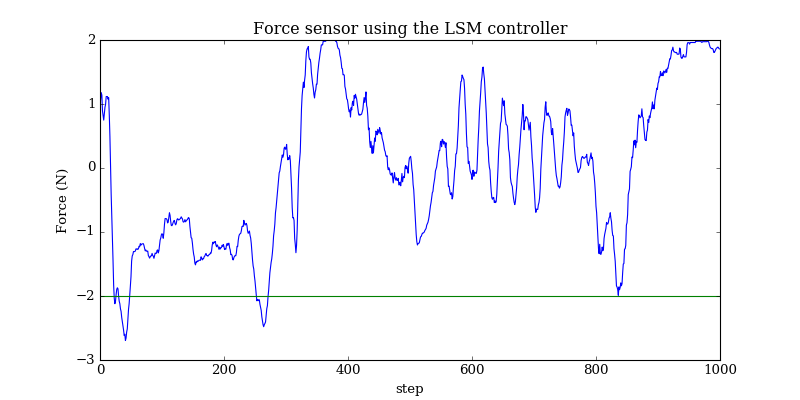

<IPython.core.display.Javascript object>


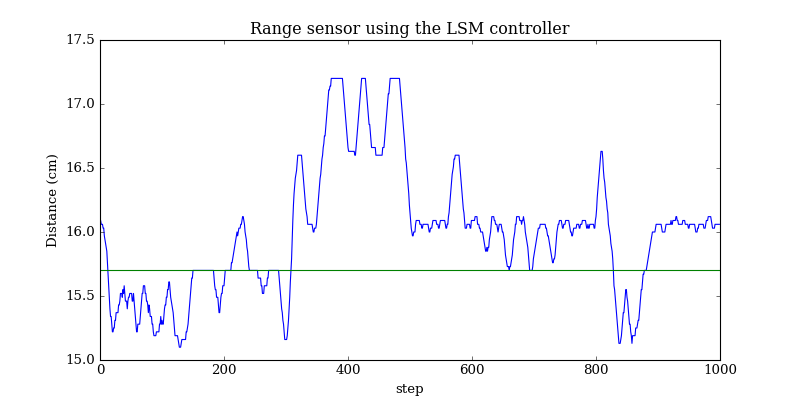

<IPython.core.display.Javascript object>


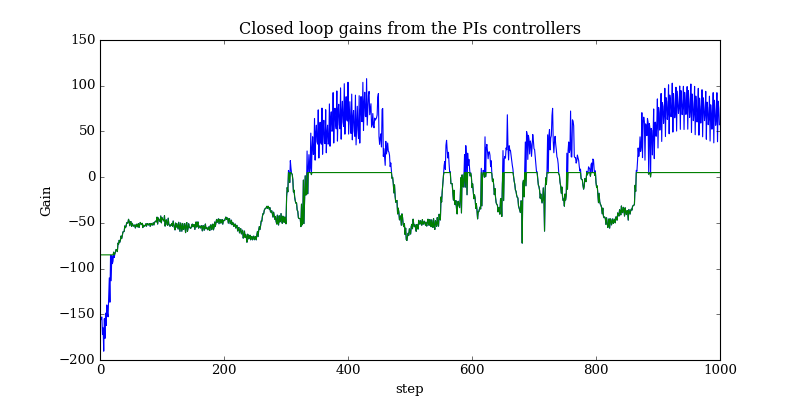

In [19]:

plt.figure(figsize=(10,5))
plt.plot(Zforce_hist)
plt.plot(numpy.ones(1000)*force_sensor_setpoint)
plt.title("Force sensor using the LSM controller")
plt.ylabel("Force (N)")
plt.xlabel("step")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ir_sensor)
plt.plot(numpy.ones(1000)*range_sensor_setpoint)
plt.title("Range sensor using the LSM controller")
plt.ylabel("Distance (cm)")
plt.xlabel("step")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(lsm_output_hist)
plt.plot(numpy.clip(lsm_output_hist,-85,5))
plt.title("Closed loop gains from the PIs controllers")
plt.ylabel("Gain")
plt.xlabel("step")
plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(pidR_hist)
# plt.title("Closed loop gains from the PIs controllers")
# plt.ylabel("Gain")
# plt.xlabel("step")
# plt.show()
